# Image Classification with Logistic Regression (Minimal)

In [1]:
# Imports
import torch
import torchvision
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torch.utils.data import random_split
from torch.utils.data import DataLoader

In [2]:
# Hyperparmeters
batch_size = 128
learning_rate = 0.001

# Other constants
input_size = 28*28
num_classes = 10

## Dataset & Data loaders

In [3]:
# Download dataset
dataset = MNIST(root='data/', train=True, transform=transforms.ToTensor(), download=True)

# Training validation & test dataset
train_ds, val_ds = random_split(dataset, [50000, 10000])
test_ds = MNIST(root='data/', train=False, transform=transforms.ToTensor())

# Dataloaders
train_loader = DataLoader(train_ds, batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size*2)
test_loader = DataLoader(test_ds, batch_size*2)

Label: 6


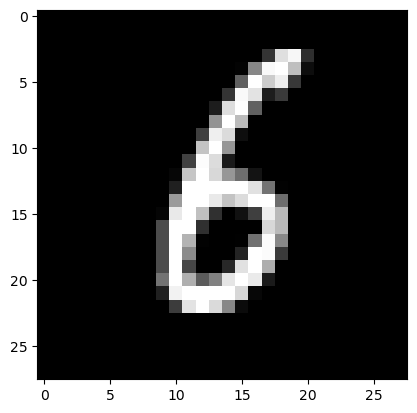

In [4]:
image, label = train_ds[0]
plt.imshow(image[0], cmap='gray')
print('Label:', label)

## Model

In [5]:
class MnistModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(input_size, num_classes)

    def forward(self, xb):
        xb = xb.reshape(-1, 784)
        out = self.linear(xb)
        return out

    def training_step(self, batch):
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc.detach()}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

model = MnistModel()

## Training

In [6]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [7]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [8]:
evaluate(model, val_loader)

{'val_loss': 2.3349969387054443, 'val_acc': 0.07744140923023224}

In [9]:
history = fit(10, 0.001, model, train_loader, val_loader)

Epoch [0], val_loss: 1.9708, val_acc: 0.6007
Epoch [1], val_loss: 1.6994, val_acc: 0.7229
Epoch [2], val_loss: 1.4959, val_acc: 0.7558
Epoch [3], val_loss: 1.3422, val_acc: 0.7782
Epoch [4], val_loss: 1.2240, val_acc: 0.7928
Epoch [5], val_loss: 1.1312, val_acc: 0.8027
Epoch [6], val_loss: 1.0569, val_acc: 0.8108
Epoch [7], val_loss: 0.9961, val_acc: 0.8162
Epoch [8], val_loss: 0.9457, val_acc: 0.8227
Epoch [9], val_loss: 0.9030, val_acc: 0.8258


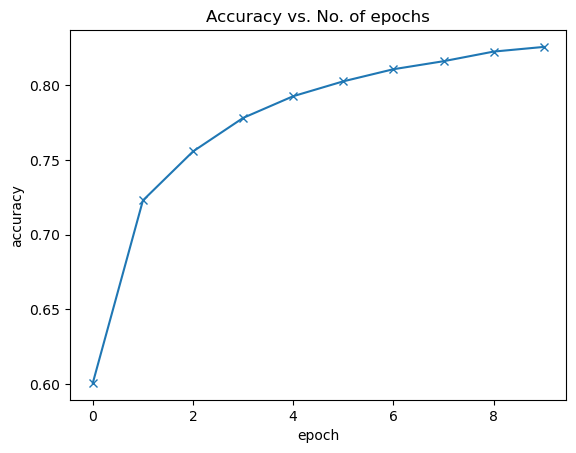

In [10]:
accuracies = [r['val_acc'] for r in history]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. No. of epochs');

In [11]:
# Evaluate on test dataset
result = evaluate(model, test_loader)
result

{'val_loss': 0.8639228940010071, 'val_acc': 0.837597668170929}

## Prediction

In [12]:
def predict_image(img, model):
    xb = img.unsqueeze(0)
    yb = model(xb)
    _, preds  = torch.max(yb, dim=1)
    return preds[0].item()

Label: 9 , Predicted: 9


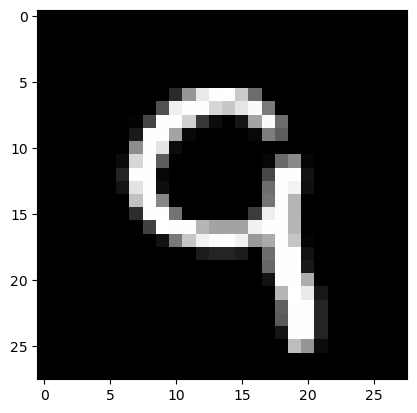

In [13]:
img, label = test_ds[913]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

In [25]:
torch.save(model.state_dict(), 'mnist_model.pth')

- Input Features: The model flattens the 28x28 pixel images into a vector of 784 features.
- Linear Combination: The linear layer computes a linear combination of these features.
- Softmax: The cross-entropy loss applies the softmax function to convert logits to probabilities.
- Classification: The model classifies the input images into one of the 10 digit classes.

Thus, this model is performing logistic regression, where the only layer is a linear layer, and the loss function used for training ensures that the output behaves like probabilities for a multiclass classification problem.

## IMPROVISING USING RANDOM FOREST

In [14]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [15]:
mnist = fetch_openml('mnist_784')
X, y = mnist.data.to_numpy(), mnist.target.to_numpy()

/home/poulami/anaconda3/lib/python3.11/site-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [16]:
X = X / 255.0
y = y.astype(int)

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [18]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [19]:
y_pred = rf_model.predict(X_test)

In [20]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Random Forest Model Accuracy: {accuracy * 100:.2f}%")

Random Forest Model Accuracy: 96.75%


In [21]:
def predict_image(img, model):
    return model.predict([img])[0]

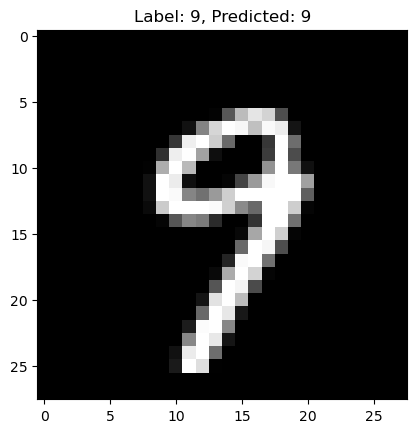

In [22]:
img_index = 913
if img_index < len(X_test):
    img = X_test[img_index]
    label = y_test[img_index]
    predicted_label = predict_image(img, rf_model)

    plt.imshow(img.reshape(28, 28), cmap='gray')
    plt.title(f"Label: {label}, Predicted: {predicted_label}")
    plt.show()
else:
    print(f"Index {img_index} is out of bounds for the test dataset.")

In [26]:
joblib.dump(rf_model, 'random_forest_model.joblib')

['random_forest_model.joblib']